In [33]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
import operator

load_dotenv()

True

In [34]:
generator_llm = ChatGroq(model="llama3-70b-8192")
evaluator_llm = ChatGroq(model="llama3-8b-8192")
optimizer_llm = ChatGroq(model="llama3-70b-8192")

In [35]:
evaluator_llm.invoke("Test")

AIMessage(content="It looks like you've sent a simple test message! Is there anything else I can help you with?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 11, 'total_tokens': 33, 'completion_time': 0.016963685, 'prompt_time': 0.002474358, 'queue_time': 0.264075293, 'total_time': 0.019438043}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c37e90dd-660e-4144-9617-9fcabd468564-0', usage_metadata={'input_tokens': 11, 'output_tokens': 22, 'total_tokens': 33})

In [36]:
class AnswerState(TypedDict):
    question: str
    answer: str
    feedback: str
    evaluation: Literal['accepted',"rejected"]
    feedback_history: Annotated[list[str],operator.add]
    answer_history: Annotated[list[str],operator.add]

    iteration: int
    max_iteration: int

In [89]:
from pydantic import BaseModel, Field

class EvaluationOutput(BaseModel):
    evaluation: Literal["accepted","rejected"] = Field(..., description="Final evaluation result")
    feedback: str = Field(..., description="feedback for the answer on how to make it sound Human written")


structured_evaluator_llm = evaluator_llm.with_structured_output(EvaluationOutput)

In [111]:
def generate(state: AnswerState):
    messages = [
        SystemMessage(content=(
            "You are a scholar tasked with producing an academic response to the user’s question. "
            "Write the answer in a formal, scholarly tone, ensuring it resembles prose written by a human academic. "
            "The response should feature varied sentence structures, nuanced vocabulary appropriate to the topic, and a logical flow of ideas that reflects deep engagement with the subject matter. "
            "Avoid formulaic or repetitive phrasing, overly uniform sentence lengths, or generic statements that lack specificity. "
            "Do not use bullet points, lists, or other structured formats; instead, craft a cohesive paragraph that integrates evidence, reasoning, and subtle stylistic variations to mimic human writing. "
            "If the topic requires, incorporate contextual details or hypothetical examples to demonstrate critical thinking. "
            f"Question: {state['question']}"
        )),
        HumanMessage(content=f"Question: {state['question']}")
    ]

    print("generate done")

    response = generator_llm(messages).content

    return {'answer': response}


def evaluate(state: AnswerState):
    print(f"IN evaluation {state['iteration']}")
    messages = [
        SystemMessage(content=(
            "You are an expert at identifying whether an academic answer was written by a human or generated by AI. "
            "You will be given a question and an answer. Based on the answer, determine whether it was likely written by a human or generated by an AI. "
            "If its Ai generated, say rejected. else accepted, also if its Ai generated then give feedbacks on how to make it sound human written."
        )),
        HumanMessage(content=f"Question: {state['question']}\n\nAnswer: {state['answer']}")
    ]

    response = structured_evaluator_llm.invoke(messages)
    print(response)
    return {
        "evaluation": response.evaluation,  # 'accepted' or 'rejected'
        "feedback": response.feedback if response.evaluation == "rejected" else None,
        "feedback_history": [response.feedback] if response.evaluation == "rejected" else []
    }

def optimize(state: AnswerState):
    print(f"Optimize {state['iteration']}")
    messages = [
        SystemMessage(content=(
            "You are a scholar tasked with refining an academic answer to enhance its resemblance to human-written prose while preserving its intellectual rigor. "
            "Revise the provided answer based on the specific feedback, ensuring it remains accurate, relevant to the question, and maintains a formal academic tone. "
            "Incorporate the feedback by adjusting sentence structure, vocabulary, or reasoning to introduce stylistic variation, nuanced word choices, or contextual depth that reflect human academic writing."
            "Only return the optimized answer and nothing else"
        )),
        HumanMessage(content=(
            f"Question: {state['question']}\n"
            f"Original Answer: {state['answer']}\n"
            f"Feedback: {state['feedback']}\n"
            f"Previous feedbacks: {state['feedback_history']}"
        ))
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {"answer": response, "iteration": iteration, "answer_history": [response]}

    


In [112]:
def route_evaluation(state: AnswerState):

    if state['evaluation'] == "accepted" or state['iteration'] >= state['max_iteration']:
        return "accepted"
    
    else:
        return "rejected"

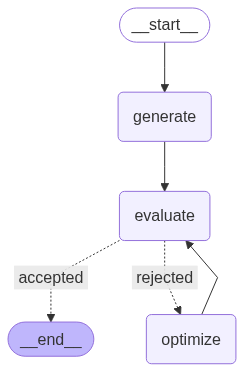

In [113]:
graph = StateGraph(AnswerState)

graph.add_node("generate",generate)
graph.add_node("evaluate",evaluate)
graph.add_node("optimize",optimize)


graph.add_edge(START, "generate")
graph.add_edge("generate","evaluate")
graph.add_conditional_edges("evaluate",route_evaluation,{"accepted":END,"rejected":"optimize"})

graph. add_edge("optimize","evaluate")

workflow = graph.compile()
workflow

In [114]:
initial_state = {
    "question": "Short note on network function virtualization in simple language",
    "iteration": 1,
    "max_iteration": 5
    
}

result = workflow.invoke(initial_state)


generate done
IN evaluation 1
evaluation='rejected' feedback='The answer lacks a clear structure and is too lengthy. It would be more effective to break it down into smaller paragraphs and focus on the main points. Additionally, some sentences are unclear or overly complex and could be rephrased for better comprehension.'
Optimize 1
IN evaluation 2
evaluation='rejected' feedback='The answer is well-written, but it lacks a clear and concise introduction to the concept of Network Function Virtualization (NFV). The language used is formal and technical, but it would be beneficial to provide a brief overview of the topic and its significance before delving into the details. Additionally, some sentences could be rephrased for better readability and clarity.'
Optimize 2
IN evaluation 3
evaluation='rejected' feedback='The language used is formal and technical, but overly complex. Consider simplifying the vocabulary and sentence structure to make it more accessible to a general audience. Use s

In [115]:
for i in result['answer_history']:
    print(i)
    print("----"*10)

Here is a revised version of the answer:

Network Function Virtualization (NFV) is a revolutionary technology that transforms the way network services are designed, deployed, and managed. By decoupling network functions from proprietary hardware, NFV enables their virtualization and deployment on standard servers. This approach eliminates the need for dedicated hardware appliances, empowering Communication Service Providers (CSPs) to transition from traditional, hardware-centric architectures to more agile, software-defined environments.

The virtualization of network functions, such as firewalls, routers, and intrusion detection systems, offers several benefits. It facilitates greater scalability, flexibility, and cost savings. Moreover, NFV creates an open, interoperable ecosystem, allowing multiple vendors to provide virtualized network functions that can be easily integrated and managed. This ecosystem accelerates innovation, reduces time-to-market for new services, and enhances ov

In [116]:
for i in result['feedback_history']:
    print(i)
    print("----"*10)

The answer lacks a clear structure and is too lengthy. It would be more effective to break it down into smaller paragraphs and focus on the main points. Additionally, some sentences are unclear or overly complex and could be rephrased for better comprehension.
----------------------------------------
The answer is well-written, but it lacks a clear and concise introduction to the concept of Network Function Virtualization (NFV). The language used is formal and technical, but it would be beneficial to provide a brief overview of the topic and its significance before delving into the details. Additionally, some sentences could be rephrased for better readability and clarity.
----------------------------------------
The language used is formal and technical, but overly complex. Consider simplifying the vocabulary and sentence structure to make it more accessible to a general audience. Use shorter sentences and paragraphs to improve readability. Additionally, avoid using jargon and acronym